In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [69]:
df = pd.read_csv('../../report/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['label', 'id', 'Date', 'Query', 'User', 'text']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [70]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [71]:
df = df.sample(n=10000)

/scratch/ddupertu/.conda/envs/history-digital/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


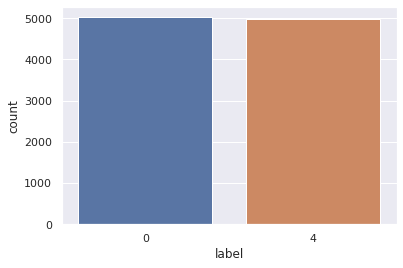

In [72]:
sns.countplot(df['label']);

In [73]:
df['label'] = df.label.replace(4,1)

In [74]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [75]:
df['text'] = df.text.apply(process_text)

In [76]:
labels = df.label.values
text = df.text.values

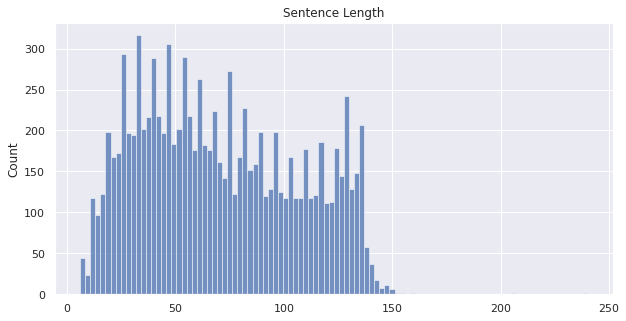

In [77]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [78]:
df = df[np.array([len(sent) for sent in df.text]) <= 150]

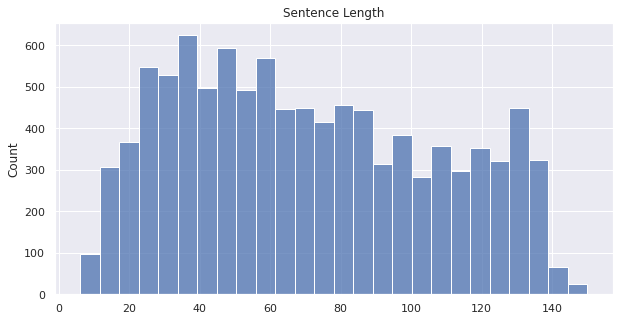

In [79]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text])
plt.title('Sentence Length')
plt.show()

In [80]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  150


In [81]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [82]:
df['data_type'] = ['not_set'] * df.shape[0]

In [83]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby(['label', 'data_type']).count()

text
label data_type      
0     train      4269
      val         753
1     train      4224
      val         746

In [84]:
from transformers import BertTokenizer

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case = True)

In [86]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = 'longest',
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = 'longest',
                                                return_tensors = 'pt')

In [87]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [88]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [89]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [90]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step


In [91]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)


/scratch/ddupertu/.conda/envs/history-digital/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [92]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [93]:
import numpy as np

def accuracy(preds,labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [94]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [96]:
from tqdm import tqdm

In [97]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'../../report/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_ave}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy (weighted): {val_acc}')

Epoch 1:  12%|█████▉                                          | 33/266 [00:17<02:01,  1.92it/s, training_loss=0.220]


Epoch 1:  25%|████████████                                    | 67/266 [00:35<01:56,  1.70it/s, training_loss=0.165]


Epoch 1:  38%|█████████████████▊                             | 101/266 [00:55<01:38,  1.68it/s, training_loss=0.189]


Epoch 1:  51%|███████████████████████▊                       | 135/266 [01:15<01:14,  1.75it/s, training_loss=0.119]


Epoch 1:  64%|█████████████████████████████▊                 | 169/266 [01:35<00:56,  1.71it/s, training_loss=0.157]


Epoch 1:  76%|███████████████████████████████████▊           | 203/266 [01:55<00:37,  1.67it/s, training_loss=0.126]


Epoch 1:  89%|█████████████████████████████████████████▉     | 237/266 [02:15<00:17,  1.69it/s, training_loss=0.202]


  0%|                                                                                        | 0/10 [02:33<?, ?it/s]


 Epoch 1
Training loss: 0.4983245110825488



 10%|███████▉                                                                       | 1/10 [02:38<23:45, 158.37s/it]

Validation loss: 0.42456684879800105
Accuracy (weighted): 0.8085390260173448



Epoch 2:  12%|█████▉                                          | 33/266 [00:19<02:09,  1.80it/s, training_loss=0.069]


Epoch 2:  25%|████████████                                    | 67/266 [00:39<01:55,  1.72it/s, training_loss=0.123]


Epoch 2:  38%|█████████████████▊                             | 101/266 [00:58<01:35,  1.73it/s, training_loss=0.083]


Epoch 2:  51%|███████████████████████▊                       | 135/266 [01:18<01:12,  1.80it/s, training_loss=0.117]


Epoch 2:  64%|█████████████████████████████▊                 | 169/266 [01:37<00:55,  1.75it/s, training_loss=0.100]


Epoch 2:  76%|███████████████████████████████████▊           | 203/266 [01:56<00:35,  1.79it/s, training_loss=0.101]


Epoch 2:  89%|█████████████████████████████████████████▉     | 237/266 [02:15<00:16,  1.78it/s, training_loss=0.111]


 10%|███████▉                                                                       | 1/10 [05:10<23:45, 158.37s/it]


 Epoch 2
Training loss: 0.35765169969850913



 20%|███████████████▊                                                               | 2/10 [05:14<20:58, 157.32s/it]

Validation loss: 0.43221428546499696
Accuracy (weighted): 0.8065376917945297



Epoch 3:  12%|█████▉                                          | 33/266 [00:19<02:14,  1.73it/s, training_loss=0.081]


Epoch 3:  25%|████████████                                    | 67/266 [00:38<01:52,  1.77it/s, training_loss=0.060]


Epoch 3:  38%|█████████████████▊                             | 101/266 [00:57<01:31,  1.81it/s, training_loss=0.131]


Epoch 3:  51%|███████████████████████▊                       | 135/266 [01:16<01:15,  1.74it/s, training_loss=0.074]


Epoch 3:  64%|█████████████████████████████▊                 | 169/266 [01:36<00:52,  1.83it/s, training_loss=0.106]


Epoch 3:  76%|███████████████████████████████████▊           | 203/266 [01:54<00:34,  1.80it/s, training_loss=0.150]


Epoch 3:  89%|█████████████████████████████████████████▉     | 237/266 [02:13<00:16,  1.73it/s, training_loss=0.063]


 20%|███████████████▊                                                               | 2/10 [07:45<20:58, 157.32s/it]


 Epoch 3
Training loss: 0.2868558659421322



 30%|███████████████████████▋                                                       | 3/10 [07:50<18:14, 156.29s/it]

Validation loss: 0.4533773185090816
Accuracy (weighted): 0.8085390260173448



Epoch 4:  12%|█████▉                                          | 33/266 [00:19<02:14,  1.73it/s, training_loss=0.039]


Epoch 4:  25%|████████████                                    | 67/266 [00:38<01:49,  1.82it/s, training_loss=0.055]


Epoch 4:  38%|█████████████████▊                             | 101/266 [00:57<01:32,  1.78it/s, training_loss=0.040]


Epoch 4:  51%|███████████████████████▊                       | 135/266 [01:16<01:15,  1.74it/s, training_loss=0.131]


Epoch 4:  64%|█████████████████████████████▊                 | 169/266 [01:36<00:56,  1.72it/s, training_loss=0.051]


Epoch 4:  76%|███████████████████████████████████▊           | 203/266 [01:55<00:35,  1.77it/s, training_loss=0.035]


Epoch 4:  89%|█████████████████████████████████████████▉     | 237/266 [02:14<00:15,  1.82it/s, training_loss=0.033]


 30%|███████████████████████▋                                                       | 3/10 [10:20<18:14, 156.29s/it]


 Epoch 4
Training loss: 0.21691681932013734



 40%|███████████████████████████████▌                                               | 4/10 [10:24<15:33, 155.63s/it]

Validation loss: 0.5395142581868679
Accuracy (weighted): 0.8058705803869246



Epoch 5:  12%|█████▉                                          | 33/266 [00:18<02:05,  1.86it/s, training_loss=0.101]


Epoch 5:  25%|████████████                                    | 67/266 [00:36<01:48,  1.84it/s, training_loss=0.010]


Epoch 5:  38%|█████████████████▊                             | 101/266 [00:55<01:32,  1.78it/s, training_loss=0.053]


Epoch 5:  51%|███████████████████████▊                       | 135/266 [01:14<01:11,  1.83it/s, training_loss=0.023]


Epoch 5:  64%|█████████████████████████████▊                 | 169/266 [01:32<00:53,  1.81it/s, training_loss=0.059]


Epoch 5:  76%|███████████████████████████████████▊           | 203/266 [01:52<00:35,  1.76it/s, training_loss=0.107]


Epoch 5:  89%|█████████████████████████████████████████▉     | 237/266 [02:11<00:16,  1.75it/s, training_loss=0.022]


 40%|███████████████████████████████▌                                               | 4/10 [12:53<15:33, 155.63s/it]


 Epoch 5
Training loss: 0.15818841381810775



 50%|███████████████████████████████████████▌                                       | 5/10 [12:57<12:53, 154.67s/it]

Validation loss: 0.6033237915723881
Accuracy (weighted): 0.8072048032021347



Epoch 6:  12%|█████▉                                          | 33/266 [00:19<02:10,  1.78it/s, training_loss=0.006]


Epoch 6:  25%|████████████                                    | 67/266 [00:38<01:48,  1.84it/s, training_loss=0.054]


Epoch 6:  38%|█████████████████▊                             | 101/266 [00:56<01:29,  1.84it/s, training_loss=0.049]


Epoch 6:  51%|███████████████████████▊                       | 135/266 [01:15<01:13,  1.78it/s, training_loss=0.126]


Epoch 6:  64%|█████████████████████████████▊                 | 169/266 [01:34<00:53,  1.82it/s, training_loss=0.027]


Epoch 6:  76%|███████████████████████████████████▊           | 203/266 [01:53<00:36,  1.72it/s, training_loss=0.021]


Epoch 6:  89%|█████████████████████████████████████████▉     | 237/266 [02:12<00:16,  1.76it/s, training_loss=0.011]


 50%|███████████████████████████████████████▌                                       | 5/10 [15:27<12:53, 154.67s/it]


 Epoch 6
Training loss: 0.11502610124241476



 60%|███████████████████████████████████████████████▍                               | 6/10 [15:31<10:17, 154.43s/it]

Validation loss: 0.6934045572230156
Accuracy (weighted): 0.8018679119412941



Epoch 7:  12%|█████▉                                          | 33/266 [00:19<02:12,  1.76it/s, training_loss=0.048]


Epoch 7:  25%|████████████                                    | 67/266 [00:38<01:49,  1.81it/s, training_loss=0.004]


Epoch 7:  38%|█████████████████▊                             | 101/266 [00:56<01:31,  1.81it/s, training_loss=0.005]


Epoch 7:  51%|███████████████████████▊                       | 135/266 [01:15<01:14,  1.75it/s, training_loss=0.049]


Epoch 7:  64%|█████████████████████████████▊                 | 169/266 [01:35<00:55,  1.76it/s, training_loss=0.029]


Epoch 7:  76%|███████████████████████████████████▊           | 203/266 [01:54<00:35,  1.79it/s, training_loss=0.055]


Epoch 7:  89%|█████████████████████████████████████████▉     | 237/266 [02:12<00:15,  1.88it/s, training_loss=0.043]


 60%|███████████████████████████████████████████████▍                               | 6/10 [18:00<10:17, 154.43s/it]


 Epoch 7
Training loss: 0.09321633955162663



 70%|███████████████████████████████████████████████████████▎                       | 7/10 [18:04<07:42, 154.01s/it]

Validation loss: 0.741095911315147
Accuracy (weighted): 0.8078719146097398



Epoch 8:  12%|█████▉                                          | 33/266 [00:18<02:09,  1.80it/s, training_loss=0.099]


Epoch 8:  25%|████████████                                    | 67/266 [00:37<01:53,  1.75it/s, training_loss=0.070]


Epoch 8:  38%|█████████████████▊                             | 101/266 [00:56<01:28,  1.87it/s, training_loss=0.014]


Epoch 8:  51%|███████████████████████▊                       | 135/266 [01:15<01:11,  1.84it/s, training_loss=0.006]


Epoch 8:  64%|█████████████████████████████▊                 | 169/266 [01:34<00:55,  1.76it/s, training_loss=0.002]


Epoch 8:  76%|███████████████████████████████████▊           | 203/266 [01:53<00:36,  1.74it/s, training_loss=0.005]


Epoch 8:  89%|█████████████████████████████████████████▉     | 237/266 [02:12<00:15,  1.83it/s, training_loss=0.080]


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [20:33<07:42, 154.01s/it]


 Epoch 8
Training loss: 0.07549377370545206



 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [20:38<05:07, 153.85s/it]

Validation loss: 0.8075579480921968
Accuracy (weighted): 0.8038692461641094



Epoch 9:  12%|█████▉                                          | 33/266 [00:19<02:13,  1.74it/s, training_loss=0.002]


Epoch 9:  25%|████████████                                    | 67/266 [00:38<01:53,  1.75it/s, training_loss=0.042]


Epoch 9:  38%|█████████████████▊                             | 101/266 [00:58<01:34,  1.74it/s, training_loss=0.002]


Epoch 9:  51%|███████████████████████▊                       | 135/266 [01:16<01:09,  1.88it/s, training_loss=0.061]


Epoch 9:  64%|█████████████████████████████▊                 | 169/266 [01:35<00:54,  1.77it/s, training_loss=0.003]


Epoch 9:  76%|███████████████████████████████████▊           | 203/266 [01:54<00:33,  1.88it/s, training_loss=0.003]


Epoch 9:  89%|█████████████████████████████████████████▉     | 237/266 [02:13<00:16,  1.77it/s, training_loss=0.002]


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [23:07<05:07, 153.85s/it]


 Epoch 9
Training loss: 0.0679298266908504



 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [23:11<02:33, 153.82s/it]

Validation loss: 0.8187924128897647
Accuracy (weighted): 0.8065376917945297



Epoch 10:  12%|█████▊                                         | 33/266 [00:18<02:06,  1.84it/s, training_loss=0.003]


Epoch 10:  25%|███████████▊                                   | 67/266 [00:37<01:50,  1.81it/s, training_loss=0.014]


Epoch 10:  38%|█████████████████▍                            | 101/266 [00:56<01:31,  1.81it/s, training_loss=0.047]


Epoch 10:  51%|███████████████████████▎                      | 135/266 [01:14<01:09,  1.88it/s, training_loss=0.002]


Epoch 10:  64%|█████████████████████████████▏                | 169/266 [01:32<00:51,  1.88it/s, training_loss=0.002]


Epoch 10:  76%|███████████████████████████████████           | 203/266 [01:51<00:34,  1.82it/s, training_loss=0.007]


Epoch 10:  89%|████████████████████████████████████████▉     | 237/266 [02:09<00:16,  1.80it/s, training_loss=0.001]


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [25:38<02:33, 153.82s/it]


 Epoch 10
Training loss: 0.05566823396383595



100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [25:42<00:00, 154.27s/it]

Validation loss: 0.8439906930669825
Accuracy (weighted): 0.8052034689793195
